# Example of Retrieval

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from typing import List, Tuple
import random

In [2]:
DATA_DIR = Path('./')
CSV_PATH = DATA_DIR / 'dataset2.csv'
NPZ_BOW_PATH = DATA_DIR / 'bovw_vectors_kmeans_1000.npz'

In [3]:
df = pd.read_csv(CSV_PATH)
npz_bovw = np.load(NPZ_BOW_PATH, allow_pickle=True)

In [4]:
npz_bovw

NpzFile 'bovw_vectors_kmeans_1000.npz' with keys: bovw_vectors, kmeans_centers, filenames

In [5]:
X_bovw = npz_bovw['bovw_vectors']
centers = npz_bovw['kmeans_centers']
filenames_npz = npz_bovw['filenames']
print('BoVW shape:', X_bovw.shape)
print('Centers shape:', centers.shape)
print('Filenames length:', len(filenames_npz))
print('First 3 filenames NPZ:', filenames_npz[:3])

BoVW shape: (79998, 1000)
Centers shape: (1000, 64)
Filenames length: 79998
First 3 filenames NPZ: [np.str_('Abstract_Expressionism/aaron-siskind_acolman-1-1955.jpg')
 np.str_('Abstract_Expressionism/aaron-siskind_chicago-6-1961.jpg')
 np.str_('Abstract_Expressionism/aaron-siskind_gloucester-16a-1944.jpg')]


In [6]:
styles = set()

for filename in filenames_npz.astype(str):
    style = filename.split('/')[0]
    if style not in styles:
        print(style)
    styles.add(style)

print('Unique styles found:', styles)

Abstract_Expressionism
Color_Field_Painting
Contemporary_Realism
Cubism
Early_Renaissance
Expressionism
Fauvism
High_Renaissance
Impressionism
Action_painting
Analytical_Cubism
Art_Nouveau_Modern
Baroque
Northern_Renaissance
Pointillism
Pop_Art
Post_Impressionism
Realism
Rococo
Mannerism_Late_Renaissance
Minimalism
Naive_Art_Primitivism
New_Realism
Romanticism
Ukiyo_e
Symbolism
Synthetic_Cubism
Unique styles found: {'Fauvism', 'Action_painting', 'Pointillism', 'Pop_Art', 'Post_Impressionism', 'Synthetic_Cubism', 'High_Renaissance', 'Cubism', 'Abstract_Expressionism', 'Impressionism', 'Realism', 'Analytical_Cubism', 'Northern_Renaissance', 'Minimalism', 'Mannerism_Late_Renaissance', 'New_Realism', 'Symbolism', 'Early_Renaissance', 'Rococo', 'Romanticism', 'Contemporary_Realism', 'Ukiyo_e', 'Naive_Art_Primitivism', 'Expressionism', 'Baroque', 'Color_Field_Painting', 'Art_Nouveau_Modern'}


In [13]:
row_norms = np.linalg.norm(X_bovw, axis=1)
print('Row norms: min={:.4f} median={:.4f} max={:.4f}'.format(row_norms.min(), np.median(row_norms), row_norms.max()))
print('Row sums:  min={:.4f} median={:.4f} max={:.4f}'.format(X_bovw.sum(1).min(), np.median(X_bovw.sum(1)), X_bovw.sum(1).max()))
print('Value range: [{:.4f}, {:.4f}]'.format(X_bovw.min(), X_bovw.max()))

Row norms: min=0.0000 median=1.0000 max=1.0000
Row sums:  min=0.0000 median=18.3779 max=24.3912
Value range: [0.0000, 1.0000]


## IN-BOVW retrieval

In [7]:
# Retrieval over existing BoVW using cosine similarity
from typing import List, Tuple
import random

# Ensure L2 normalization
X_norm = X_bovw / (np.linalg.norm(X_bovw, axis=1, keepdims=True) + 1e-12)
filename_to_idx = {fn: i for i, fn in enumerate(filenames_npz.astype(str))}


def retrieve_topk_by_vector(query_vec: np.ndarray, k: int = 10, exclude_index: int = None) -> List[Tuple[int, float]]:
    q = query_vec.astype(np.float32)
    q = q / (np.linalg.norm(q) + 1e-12)
    sims = X_norm @ q  # cosine similarity
    if exclude_index is not None:
        sims[exclude_index] = -np.inf
    idx = np.argsort(-sims)[:k]
    return [(int(i), float(sims[i])) for i in idx]


def retrieve_by_filename(fname: str, k: int = 10) -> pd.DataFrame:
    i = filename_to_idx[fname]
    q = X_norm[i]
    top = retrieve_topk_by_vector(q, k=k, exclude_index=i)
    rows = []
    for j, sim in top:
        rows.append({'rank': len(rows)+1, 'index': j, 'filename': str(filenames_npz[j]), 'similarity': sim})
    return pd.DataFrame(rows)

In [33]:
van_gogh_paintings = [f for f in filenames_npz if "van-gogh" in f]

In [35]:
len(van_gogh_paintings)

1894

In [37]:
# example for vincent van Gogh
sample_fname = str(van_gogh_paintings[random.randint(0, len(van_gogh_paintings) - 1)])
print('Query:', sample_fname)
df_nn = retrieve_by_filename(sample_fname, k=10)
print(df_nn.iloc[0]['filename'])
print(df_nn)

Query: Realism/vincent-van-gogh_peasant-man-and-woman-planting-potatoes-1885.jpg
Realism/vincent-van-gogh_studies-of-donkey-carts-1882.jpg
   rank  index                                           filename  similarity
0     1  44526  Realism/vincent-van-gogh_studies-of-donkey-car...    0.687000
1     2  34761  Post_Impressionism/vincent-van-gogh_a-sower-an...    0.682471
2     3  34949  Post_Impressionism/vincent-van-gogh_houses-amo...    0.677321
3     4  35209  Post_Impressionism/vincent-van-gogh_sheet-with...    0.676429
4     5  44473  Realism/vincent-van-gogh_sketches-of-heads-188...    0.669523
5     6  44195  Realism/vincent-van-gogh_interior-with-peasant...    0.668100
6     7  44183  Realism/vincent-van-gogh_honesty-in-a-vase-188...    0.662556
7     8  31269  Post_Impressionism/edouard-vuillard_flowers-on...    0.661157
8     9  59092  Early_Renaissance/andrea-mantegna_bird-on-a-br...    0.660041
9    10  67724  Post_Impressionism/vincent-van-gogh_couple-wal...    0.657105


/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: divide by zero encountered in matmul
  sims = X_norm @ q  # cosine similarity
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: overflow encountered in matmul
  sims = X_norm @ q  # cosine similarity
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: invalid value encountered in matmul
  sims = X_norm @ q  # cosine similarity


In [24]:
monet_paintings = [f for f in filenames_npz if "claude-monet" in f]

In [26]:
len(monet_paintings)

1343

In [40]:
# example for Claude Monet
sample_fname = str(monet_paintings[random.randint(0, len(monet_paintings) - 1)])
print('Query:', sample_fname)
df_nn = retrieve_by_filename(sample_fname, k=10)
print(df_nn.iloc[0]['filename'])
print(df_nn)

Query: Impressionism/claude-monet_park-monceau-3.jpg
Impressionism/claude-monet_relaxing-in-the-garden-argenteuil.jpg
   rank  index                                           filename  similarity
0     1  15992  Impressionism/claude-monet_relaxing-in-the-gar...    0.772250
1     2  39232  Realism/ivan-shishkin_landscape-with-a-woman-1...    0.771843
2     3  38608         Realism/isaac-levitan_birch-grove-1889.jpg    0.763939
3     4  40488  Impressionism/robert-julian-onderdonk_bluebonn...    0.763174
4     5  40506  Impressionism/robert-julian-onderdonk_field-of...    0.762870
5     6  71622  Romanticism/rudolf-von-alt_the-large-pine-in-g...    0.760430
6     7  61806  Impressionism/claude-monet_the-garden-gate-at-...    0.758377
7     8  61887      Impressionism/claude-monet_water-lilies-4.jpg    0.755650
8     9  16122  Impressionism/claude-monet_the-artist-s-house-...    0.755025
9    10  61861  Impressionism/claude-monet_the-valley-of-sasso...    0.754295


/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: divide by zero encountered in matmul
  sims = X_norm @ q  # cosine similarity
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: overflow encountered in matmul
  sims = X_norm @ q  # cosine similarity
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: invalid value encountered in matmul
  sims = X_norm @ q  # cosine similarity


In [31]:
pissarro_paintings = [f for f in filenames_npz if "camille-pissarro" in f]

In [ ]:
# example for Camille Pissarro
sample_fname = str(pissarro_paintings[random.randint(0, len(pissarro_paintings) - 1)])
print('Query:', sample_fname)
df_nn = retrieve_by_filename(sample_fname, k=10)
print(df_nn.iloc[0]['filename'])
print(df_nn)

Query: Pointillism/camille-pissarro_meadow-at-bazincourt.jpg
Impressionism/john-singer-sargent_cottage-at-fairford-gloucestershire-1892.jpg
   rank  index                                           filename  similarity
0     1  19515  Impressionism/john-singer-sargent_cottage-at-f...    0.768207
1     2  61475  Impressionism/camille-pissarro_thaw-pontoise-1...    0.761160
2     3  19311  Impressionism/john-henry-twachtman_gloucester-...    0.754788
3     4  15052  Impressionism/camille-pissarro_the-treasury-an...    0.752699
4     5  10690  Fauvism/georges-braque_landscape-at-la-ciotat-...    0.751311
5     6  15223  Impressionism/childe-hassam_conversation-on-th...    0.747756
6     7  32829  Post_Impressionism/maurice-prendergast_st-malo...    0.746841
7     8  14866  Impressionism/camille-pissarro_street-snow-eff...    0.744922
8     9  46548    Impressionism/t.-c.-steele_the-poplars-1914.jpg    0.743375
9    10  46514  Impressionism/t.-c.-steele_house-of-the-singin...    0.743239


/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: divide by zero encountered in matmul
  sims = X_norm @ q  # cosine similarity
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: overflow encountered in matmul
  sims = X_norm @ q  # cosine similarity
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: invalid value encountered in matmul
  sims = X_norm @ q  # cosine similarity


In [15]:
# example
sample_fname = str(filenames_npz[random.randint(0, len(filenames_npz) - 1)])
print('Query:', sample_fname)
df_nn = retrieve_by_filename(sample_fname, k=10)
print(df_nn.iloc[0]['filename'])
print(df_nn)

Query: Art_Nouveau_Modern/gustav-klimt_allegory-of-sculpture.jpg
Art_Nouveau_Modern/raphael-kirchner_unknown-9.jpg
   rank  index                                           filename  similarity
0     1  21859  Art_Nouveau_Modern/raphael-kirchner_unknown-9.jpg    0.897259
1     2   6781  Expressionism/ernst-ludwig-kirchner_dancer-191...    0.894382
2     3  56667  Art_Nouveau_Modern/aubrey-beardsley_the-murder...    0.888190
3     4   6769  Expressionism/ernst-ludwig-kirchner_colourful-...    0.881274
4     5  60339  Expressionism/pablo-picasso_portrait-of-olga-1...    0.880300
5     6  56995  Art_Nouveau_Modern/koloman-moser_character-stu...    0.878166
6     7  59634  Expressionism/egon-schiele_clothed-woman-recli...    0.875719
7     8  28515  Pop_Art/andy-warhol_ingrid-bergman-as-herself.jpg    0.866641
8     9  13636  Art_Nouveau_Modern/aubrey-beardsley_the-kiss-o...    0.865952
9    10   3952                    Cubism/pablo-picasso_studio.jpg    0.864910


/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: divide by zero encountered in matmul
  sims = X_norm @ q  # cosine similarity
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: overflow encountered in matmul
  sims = X_norm @ q  # cosine similarity
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: invalid value encountered in matmul
  sims = X_norm @ q  # cosine similarity


In [8]:
top10_retrieval_100 = []
rng = np.random.default_rng(42)
for i in range(100):
    sample_idx = rng.integers(0, len(filenames_npz))
    sample_fname = str(filenames_npz[sample_idx])
    df_nn = retrieve_by_filename(sample_fname, k=10)
    top10_retrieval_100.append(df_nn['similarity'].values)
    if (i + 1) % 20 == 0:
        print(f'Completed {i + 1}/100 queries')

top10_retrieval_100 = np.array(top10_retrieval_100)
print(f'\nShape of results: {top10_retrieval_100.shape}')
print(f'Mean similarities across 100 queries: {top10_retrieval_100.mean(axis=0)}')
print(f'Mean similarity for rank 1: {top10_retrieval_100[:, 0].mean():.4f}')
print(f'Mean similarity for rank 10: {top10_retrieval_100[:, 9].mean():.4f}')

/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: divide by zero encountered in matmul
  sims = X_norm @ q  # cosine similarity
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: overflow encountered in matmul
  sims = X_norm @ q  # cosine similarity
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3272496319.py:13: RuntimeWarning: invalid value encountered in matmul
  sims = X_norm @ q  # cosine similarity


Completed 20/100 queries
Completed 40/100 queries
Completed 60/100 queries
Completed 80/100 queries
Completed 100/100 queries

Shape of results: (100, 10)
Mean similarities across 100 queries: [0.74744343 0.73970815 0.73571075 0.73214622 0.72908826 0.72714524
 0.72505168 0.72341488 0.72197314 0.72066751]
Mean similarity for rank 1: 0.7474
Mean similarity for rank 10: 0.7207


Query index: 68048
Query filename: Realism/boris-kustodiev_chairman-of-the-council-of-ministers-i-l-goremykin-1906.jpg
Stats: {'mean': 0.37752798199653625, 'median': 0.40815022587776184, 'std': 0.1454717218875885, 'min': 0.0, 'max': 0.6996583938598633}
Percentiles [1,5,10,50,90,95,99]: [0.         0.09155948 0.1634392  0.40815023 0.54219081 0.56893946
 0.61283739]


/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3066006389.py:14: RuntimeWarning: divide by zero encountered in matmul
  sims = X_norm @ X_norm[q_idx]
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3066006389.py:14: RuntimeWarning: overflow encountered in matmul
  sims = X_norm @ X_norm[q_idx]
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/3066006389.py:14: RuntimeWarning: invalid value encountered in matmul
  sims = X_norm @ X_norm[q_idx]


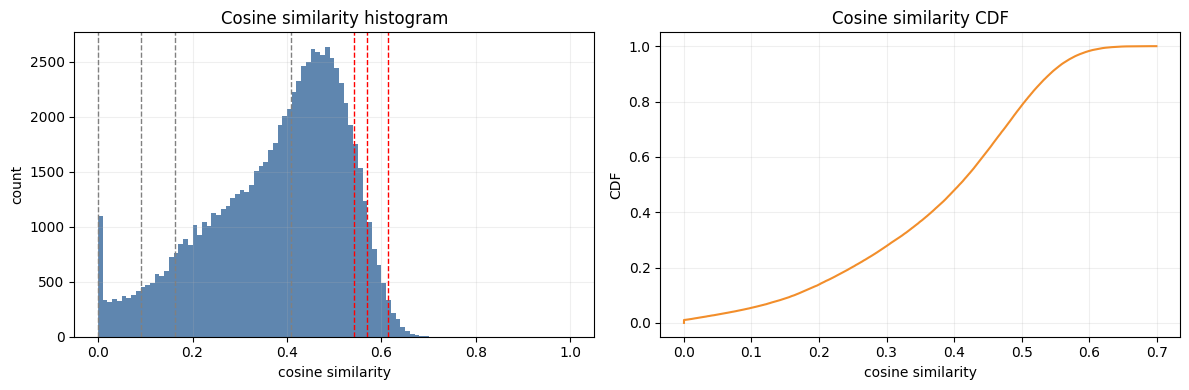

In [12]:
# Cosine similarity distribution for a random BoVW vector
import numpy as np
import matplotlib.pyplot as plt

# Ensure normalized matrix
if 'X_norm' not in globals():
    X_norm = X_bovw / (np.linalg.norm(X_bovw, axis=1, keepdims=True) + 1e-12)

rng = np.random.default_rng(0)
N = X_norm.shape[0]
q_idx = int(rng.integers(N))
q_fname = str(filenames_npz[q_idx])

sims = X_norm @ X_norm[q_idx]
sims[q_idx] = np.nan
valid = ~np.isnan(sims)
s = sims[valid]

stats = {
    'mean': float(np.mean(s)),
    'median': float(np.median(s)),
    'std': float(np.std(s)),
    'min': float(np.min(s)),
    'max': float(np.max(s)),
}
qs = np.percentile(s, [1,5,10,50,90,95,99])

print('Query index:', q_idx)
print('Query filename:', q_fname)
print('Stats:', stats)
print('Percentiles [1,5,10,50,90,95,99]:', qs)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histogram
axes[0].hist(s, bins=100, range=(0.0, 1.0), color='#4e79a7', alpha=0.9)
for p, v in zip([1,5,10,50,90,95,99], qs):
    axes[0].axvline(v, color='red' if p>=90 else 'gray', linestyle='--', linewidth=1)
axes[0].set_title('Cosine similarity histogram')
axes[0].set_xlabel('cosine similarity')
axes[0].set_ylabel('count')
axes[0].grid(True, alpha=0.2)

# CDF
s_sorted = np.sort(s)
cdf = np.linspace(0, 1, s_sorted.size)
axes[1].plot(s_sorted, cdf, color='#f28e2b')
axes[1].set_title('Cosine similarity CDF')
axes[1].set_xlabel('cosine similarity')
axes[1].set_ylabel('CDF')
axes[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/2973310154.py:23: RuntimeWarning: divide by zero encountered in matmul
  sims = X_norm @ X_norm[q_idx]
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/2973310154.py:23: RuntimeWarning: overflow encountered in matmul
  sims = X_norm @ X_norm[q_idx]
/var/folders/61/254gkcgs15ldj31k0nxcvdl00000gn/T/ipykernel_24562/2973310154.py:23: RuntimeWarning: invalid value encountered in matmul
  sims = X_norm @ X_norm[q_idx]


Completed 20/100 distributions
Completed 40/100 distributions
Completed 60/100 distributions
Completed 80/100 distributions
Completed 100/100 distributions

Aggregated stats across 100 queries:
Stats: {'mean': 0.32361915707588196, 'median': 0.33148694038391113, 'std': 0.17794941365718842, 'min': 0.0, 'max': 0.97843337059021}
Percentiles [1,5,10,50,90,95,99]: [0.         0.01590431 0.07206279 0.33148696 0.55550481 0.6008398
 0.6716975 ]


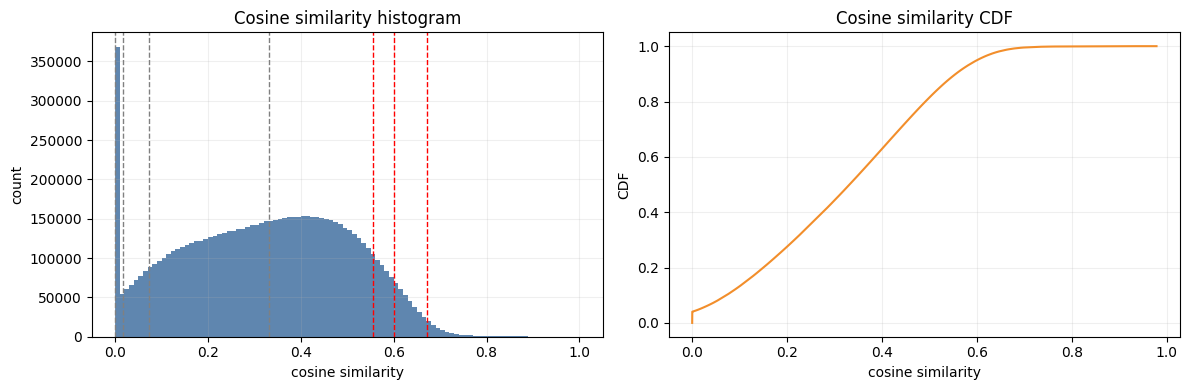

In [11]:
# Cosine similarity distribution for 100 random BoVW vectors
import numpy as np
import matplotlib.pyplot as plt

# Ensure normalized matrix
if 'X_norm' not in globals():
    X_norm = X_bovw / (np.linalg.norm(X_bovw, axis=1, keepdims=True) + 1e-12)

# row_norms = np.linalg.norm(X_bovw, axis=1)
# zero_vector_mask = row_norms < 1e-10

all_s = []
rng = np.random.default_rng(42)
N = X_norm.shape[0]
iterations = 0
while len(all_s) < 100 and iterations < 200:
    iterations += 1
    q_idx = int(rng.integers(0, N))
    
    # if zero_vector_mask[q_idx]:
    #     continue
    
    sims = X_norm @ X_norm[q_idx]
    sims[q_idx] = np.nan
    
    # non_zero_mask = ~zero_vector_mask
    # valid = ~np.isnan(sims) & non_zero_mask
    valid = ~np.isnan(sims)
    s = sims[valid]
    
    if len(s) == 0:
        continue
    
    all_s.append(s)
    
    if len(all_s) % 20 == 0:
        print(f'Completed {len(all_s)}/100 distributions')

s = np.concatenate(all_s)

stats = {
    'mean': float(np.mean(s)),
    'median': float(np.median(s)),
    'std': float(np.std(s)),
    'min': float(np.min(s)),
    'max': float(np.max(s)),
}
qs = np.percentile(s, [1,5,10,50,90,95,99])

print(f'\nAggregated stats across {len(all_s)} queries:')
print('Stats:', stats)
print('Percentiles [1,5,10,50,90,95,99]:', qs)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histogram
axes[0].hist(s, bins=100, range=(0.0, 1.0), color='#4e79a7', alpha=0.9)
for p, v in zip([1,5,10,50,90,95,99], qs):
    axes[0].axvline(v, color='red' if p>=90 else 'gray', linestyle='--', linewidth=1)
axes[0].set_title('Cosine similarity histogram')
axes[0].set_xlabel('cosine similarity')
axes[0].set_ylabel('count')
axes[0].grid(True, alpha=0.2)

# CDF
s_sorted = np.sort(s)
cdf = np.linspace(0, 1, s_sorted.size)
axes[1].plot(s_sorted, cdf, color='#f28e2b')
axes[1].set_title('Cosine similarity CDF')
axes[1].set_xlabel('cosine similarity')
axes[1].set_ylabel('CDF')
axes[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()
